# A short overview of LightFM

## By Daniel Crha

### What is LightFM?

TODO

### The LightFM model

TODO: describe how the model works

### Recommendations with MovieLens

First of all, let's try creating a model for the MovieLens dataset.
We will fit an implicit feedback model for movies with a rating of at least 3 stars.

In [9]:
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Load the MovieLens 100k dataset.
# Ratings are treated as positive if the rating is at least 3.0
ml_data = fetch_movielens(min_rating=3.0)

First of all, we will define a function which will train our model. It will simply iteratively train the model and every few epochs, it will evaluate how the model is doing.

In [10]:
def train_ml_model(ml_model):
    epoch_count = 200
    epoch_iters = range(10, epoch_count + 1, 5)
    patk_train = []
    patk_test = []

    # Let's measure how long it takes to train the model as well
    print("Training model...")
    start_time = time.time()

    old_epoch = 0
    for epoch in epoch_iters:
        more = epoch - old_epoch
        ml_model.fit_partial(ml_data["train"], epochs=more, num_threads=8)
        patk_train.append(precision_at_k(ml_model, ml_data["train"], k=5).mean())
        patk_test.append(precision_at_k(ml_model, ml_data["test"], k=5).mean())
        old_epoch = epoch


    end_time = time.time()
    print(f"Training finished! Elapsed time: {end_time - start_time:.2f} s.")
    return epoch_iters, patk_train, patk_test

Now let's create the model and train it.

We'll use the `WARP` loss function. TODO: describe WARP

In [11]:
# Instantiate and train the model
ml_model = LightFM(loss="warp")
epoch_iters, patk_train, patk_test = train_ml_model(ml_model)

Training model...
Training finished! Elapsed time: 12.36 s.


Let's check how precision @ k is looking during the course of training for both the training and test datasets.

In [12]:
# Nothing interesting here - just plotting
def plot_patk(epochs, patk, title, k=5):
    plt.plot(epochs, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('Precision @ {}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

def plot_training_evaluation(epoch_iters, patk_train, patk_test, title):
    plt.figure(figsize=(10, 6), dpi=80)
    plt.suptitle(title, fontsize=30)

    # Plot train on the left
    ax = plt.subplot(1, 2, 1)
    fig = ax.get_figure();
    sns.despine(fig);
    plot_patk(epoch_iters, patk_train,'Train', k=5)

    # Plot test on the right
    ax = plt.subplot(1, 2, 2)
    fig = ax.get_figure();
    sns.despine(fig);
    plot_patk(epoch_iters, patk_test, 'Test', k=5)

    plt.tight_layout();

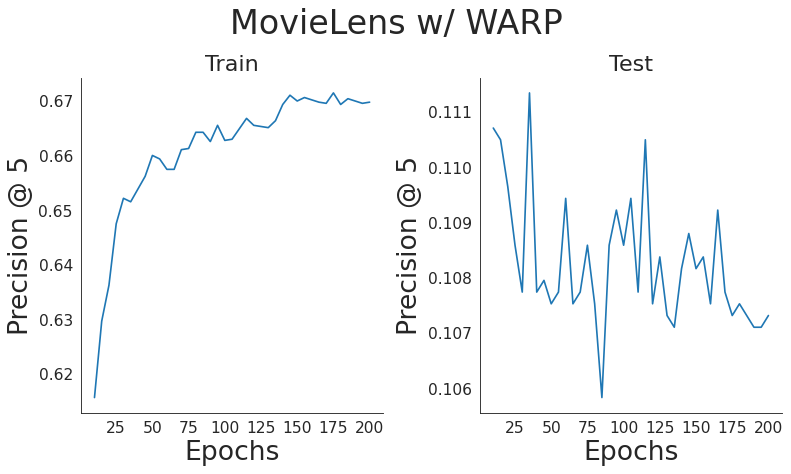

In [13]:
plot_training_evaluation(epoch_iters, patk_train, patk_test, "MovieLens w/ WARP")

# TODO: make a prediction for a user (i.e. show predicted movies given some previous movies)

We can see that after about 50 epochs, the model starts overfitting and the test precision is declining.

As far as the speedup is concerned, I tested the effects of threading on training speed.
I evaluated the speedup on 3000 epochs.
With 16 threads, the training takes about 66 seconds.
With only 1 thread, it takes about 95 seconds.
If the dataset was larger, the speedup would probably be larger as well.

For comparison, we can check how it looks when we use `BPR` instead of `WARP` as the loss function.

Training model...
Training finished! Elapsed time: 11.92 s.


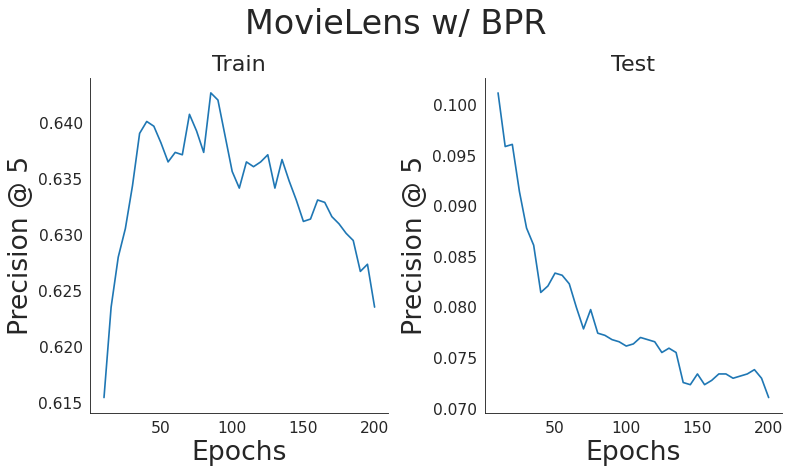

In [14]:
ml_model = LightFM(loss="bpr")
epoch_iters, patk_train, patk_test = train_ml_model(ml_model)
plot_training_evaluation(epoch_iters, patk_train, patk_test, "MovieLens w/ BPR")